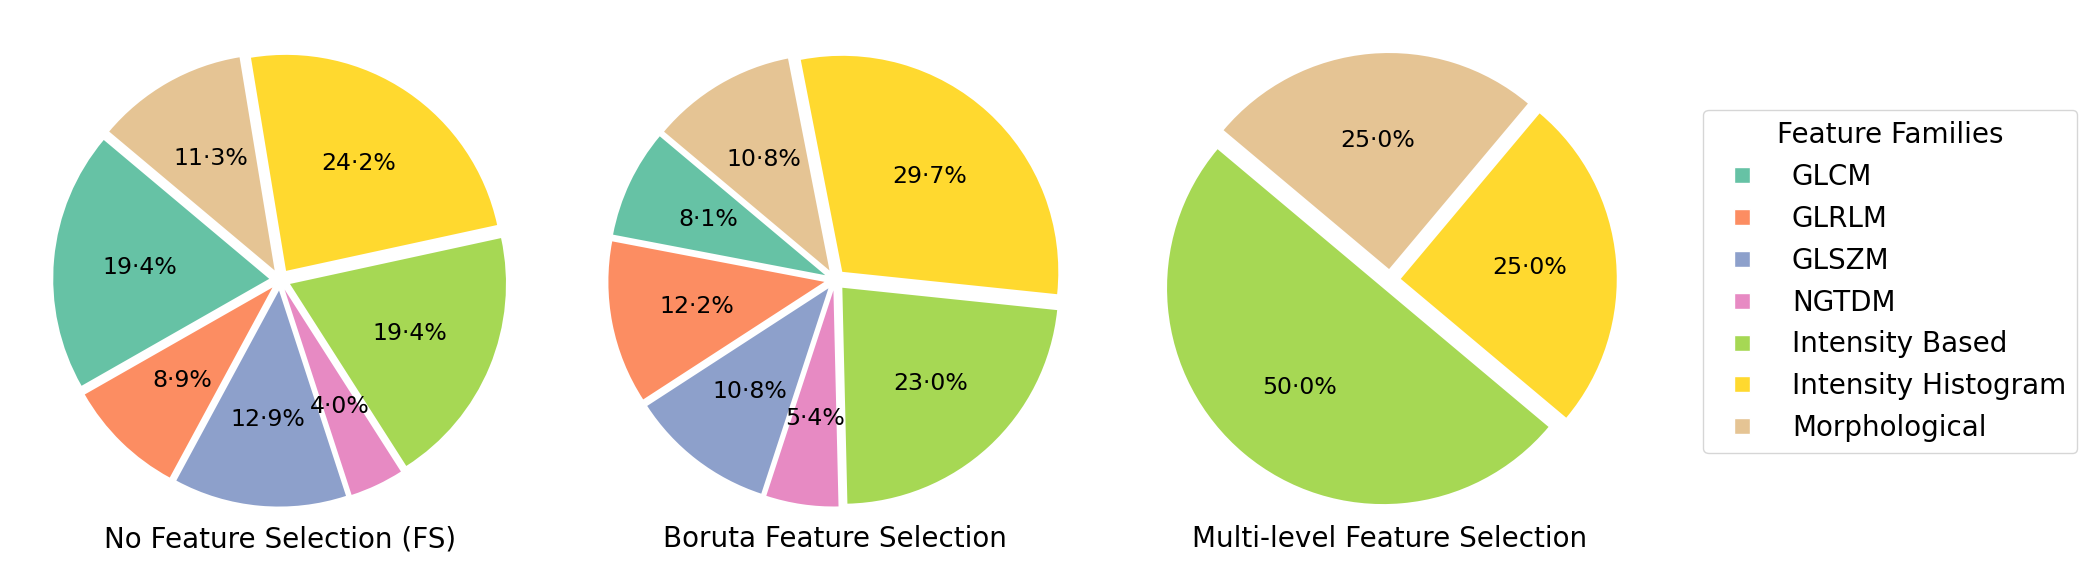

In [15]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# File paths for the 3 selected methods
excel_files = [
    '../../Elements/SMOTE_LogReg/AcrossSplits/Split4_SMOTE_LogReg_ReduceDataset.xlsx',  # No FS
    '../../Elements/Boruta_RusBoost/AcrossSplits/Split2_Boruta_RusBoost_ReduceDataset.xlsx',  
    '../../Elements/Multi_SMOTE_LogReg/AcrossSplits/Split4_Multi_SMOTE_LogReg_ReduceDataset.xlsx',
]

metrics = [
    "../../Elements/SMOTE_LogReg/AcrossSplits/scores.csv",
    "../../Elements/Boruta_RusBoost/AcrossSplits/scores.csv",
    "../../Elements/Multi_SMOTE_LogReg/AcrossSplits/scores.csv"
]

index_scores = [4, 2, 4]  # Indices where the F1-scores are located in metrics
labels_map = {
    "SMOTE_LogReg": "No Feature Selection (FS)",
    "Boruta_RusBoost": "Boruta Feature Selection",
    "Multi_SMOTE_LogReg": "Multi-level Feature Selection"
}

# Feature family patterns
patterns = {
    'GLCM': re.compile(r'BAS_GLCM_'),
    'GLRLM': re.compile(r'BAS_GLRLM_'),
    'GLSZM': re.compile(r'BAS_GLSZM_'),
    'NGTDM': re.compile(r'BAS_NGTDM_'),
    'Intensity Based': re.compile(r'BAS_INTENSITYBASED_'),
    'Intensity Histogram': re.compile(r'BAS_INTENSITYHISTOGRAM_'),
    'Morphological': re.compile(r'BAS_MORPHOLOGICAL_'),
}

# Load F1 scores
f1_scores = {}
for i, metric_file in enumerate(metrics):
    df = pd.read_csv(metric_file)
    model_key = metric_file.split('/')[3].replace(".csv", "")
    f1_scores[model_key] = df.iloc[index_scores[i]]['F1-score']

# Load and count feature types
feature_family_counts = {}
for excel_file in excel_files:
    df = pd.read_excel(excel_file)
    model_key = excel_file.split('/')[3].replace(".xlsx", "")
    counts = {family: 0 for family in patterns}
    for col in df.columns:
        for family, pattern in patterns.items():
            if pattern.match(col):
                counts[family] += 1
                break
    feature_family_counts[model_key] = counts

# Define a function to format the percentage labels with middle dot
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    formatted_pct = f"{pct:.1f}".replace(".", "·")
    return f"{formatted_pct}%"

# Plotting
plot_order = ["SMOTE_LogReg", "Boruta_RusBoost", "Multi_SMOTE_LogReg"]
n_files = len(plot_order)
fig, axes = plt.subplots(nrows=1, ncols=n_files, figsize=(7 * n_files, 14), squeeze=False)
colors = plt.get_cmap('Set2').colors
legend_labels = list(patterns.keys())

for idx, model_key in enumerate(plot_order):
    counts = feature_family_counts[model_key]
    ax = axes[0, idx]
    
    labels = list(counts.keys())
    sizes = list(counts.values())

    filtered_labels = [label for label in labels if counts[label] > 0]
    filtered_sizes = [counts[label] for label in filtered_labels]
    filtered_colors = [colors[labels.index(label)] for label in filtered_labels]
    
    explode = [0.05] * len(filtered_labels)
    
    # Create the pie chart with the percentage labels, without class names
    wedges, texts, autotexts = ax.pie(
        filtered_sizes,
        labels=None,  # No class names around the pie slices
        autopct=lambda pct: func(pct, filtered_sizes),  # Format percentage
        startangle=140,
        colors=filtered_colors,
        explode=explode
    )

    for autotext in autotexts:
        autotext.set_fontsize(17)  # ← Increase this number as needed
        autotext.set_color('black')  # Optional: high contrast


    # Add the title below the pie chart 
    ax.text(0.0, -1.2, labels_map[model_key], ha='center', va='center', fontsize=20, fontweight='normal')

# Move the legend to the right side of the plot
fig.legend(
    handles=[plt.Line2D([0], [0], marker='s', color='w', label=label, markersize=12, markerfacecolor=colors[i])
             for i, label in enumerate(legend_labels)],
    labels=legend_labels,
    loc='center right',  # Place the legend outside the plot
    fontsize=20,
    title='Feature Families',
    title_fontsize=20,
)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.80, 1])  # Shrink the layout to fit the legend
plt.savefig("feature_family_comparison.png", dpi=1000, bbox_inches='tight')
plt.show()


In [27]:
import pandas as pd
import re
import os
import numpy as np

# Patterns for identifying feature families
patterns = {
    'GLCM': re.compile(r'BAS_GLCM_'),
    'GLRLM': re.compile(r'BAS_GLRLM_'),
    'GLSZM': re.compile(r'BAS_GLSZM_'),
    'NGTDM': re.compile(r'BAS_NGTDM_'),
    'Intensity Based': re.compile(r'BAS_INTENSITYBASED_'),
    'Intensity Histogram': re.compile(r'BAS_INTENSITYHISTOGRAM_'),
    'Morphological': re.compile(r'BAS_MORPHOLOGICAL_'),
}

# Mapping for better readability in output
labels_map = {
    "SMOTE_LogReg": "No FS",
    "Boruta_RusBoost": "Boruta FS",
    "Multi_SMOTE_LogReg": "Multi-level FS"
}

# Base paths for methods
base_paths = {
    "SMOTE_LogReg": "../../Elements/SMOTE_LogReg/AcrossSplits",
    "Boruta_RusBoost": "../../Elements/Boruta_RusBoost/AcrossSplits",
    "Multi_SMOTE_LogReg": "../../Elements/Multi_SMOTE_LogReg/AcrossSplits"
}

# Store percentages in a list of rows for the final DataFrame
percentage_rows = []

# Loop over each method and each split
for method, base_path in base_paths.items():
    for split in range(0, 5):
        filename = f"Split{split}_{method}_ReduceDataset.xlsx"
        filepath = os.path.join(base_path, filename)
        
        if not os.path.isfile(filepath):
            print(f"File not found: {filepath}")
            continue
        
        df = pd.read_excel(filepath)
        
        # Count the number of features per family
        counts = {family: 0 for family in patterns}
        total = 0
        for col in df.columns:
            test = 0
            matched = False
            for family, pattern in patterns.items():
                if pattern.match(col):
                    counts[family] += 1
                    matched = True
                    test += 1
            
            assert test == 1
            assert matched
            total += 1
            

        # Avoid division by zero
        if total == 0:
            print(f"No matching features found in {filepath}")
            continue

        # Calculate percentages
        percentages = {family: (count / total) * 100 for family, count in counts.items()}
        
        # Add row to results
        row = {
            "Method": labels_map[method],
            "Split": split,
            "Total Features": total,
            **percentages
        }
        percentage_rows.append(row)

# Create a DataFrame from the collected rows
percentage_df = pd.DataFrame(percentage_rows)

# Optional: round the values
percentage_df = percentage_df.round(1)
# Display or save the result
percentage_df.to_csv("feature_family_percentages.csv", index=False)
percentage_df.to_excel("feature_family_percentages.xlsx", index=False)


percentage_df_dropped = percentage_df.drop(columns=["Method", "Split", "Total Features"])
assert np.isclose(percentage_df_dropped.sum(axis=1), 100, atol=1e-1).all()

In [28]:
percentage_df

,Method,Split,Total Features,GLCM,GLRLM,GLSZM,NGTDM,Intensity Based,Intensity Histogram,Morphological
0,No FS,0,124,19.4,8.9,12.9,4.0,19.4,24.2,11.3
1,No FS,1,124,19.4,8.9,12.9,4.0,19.4,24.2,11.3
2,No FS,2,124,19.4,8.9,12.9,4.0,19.4,24.2,11.3
3,No FS,3,124,19.4,8.9,12.9,4.0,19.4,24.2,11.3
4,No FS,4,124,19.4,8.9,12.9,4.0,19.4,24.2,11.3
5,Boruta FS,0,66,9.1,15.2,9.1,6.1,22.7,27.3,10.6
6,Boruta FS,1,60,10.0,8.3,8.3,6.7,23.3,30.0,13.3
7,Boruta FS,2,74,8.1,12.2,10.8,5.4,23.0,29.7,10.8
8,Boruta FS,3,67,9.0,14.9,10.4,6.0,20.9,26.9,11.9
9,Boruta FS,4,67,9.0,14.9,9.0,6.0,22.4,26.9,11.9
